# Set up variables for training

In [1]:
import models.VAEWavenet.WaveVaeDenoiser as WNVAE
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

def printGPUInfo():
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print("Total memory =", t)
    print("Reserved memory =", r)
    print("Allocated memory =", a)
    
# printGPUInfo()

learning_rate = 0.00001
batchsize = 32
loss_fn = torch.nn.CrossEntropyLoss(reduce = False)
device='cuda'
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# Model hyperparameters
features = 40
rec_field = 16
upsamples = [2, 2, 2, 2, 2, 2]
latent_space_dim = 64

denoiser = WNVAE.WaveNetVAE(input_size = (features, rec_field), device = device, num_hiddens = 768, dil_rates = upsamples, zsize = latent_space_dim)
denoiser.to(device)

device_count = torch.cuda.device_count()

if device_count > 1 and device.upper() == 'CUDA':
    denoiser = nn.DataParallel(denoiser)
    print('multiple device using :', device_count)

spdataset = WNVAE.WaveVaeDataset("../ConvDenoiser_Old/clips", "../ConvDenoiser_Old/urbansound", clip_length = 256, clips = 4000)
sptestdataset = WNVAE.WaveVaeDataset("../ConvDenoiser_Old/testdata", "../ConvDenoiser_Old/urbansound", clip_length = 256, clips = 50)

spdataloader = DataLoader(spdataset, batch_size=batchsize, shuffle=True, pin_memory = True, num_workers =  4 * torch.cuda.device_count())
# spdataloader = DataLoader(spdataset, batch_size=batchsize, shuffle=True, pin_memory = True)
sptestdataloader = DataLoader(sptestdataset, batch_size=batchsize, shuffle=False, pin_memory = False)


optimizer=torch.optim.AdamW(denoiser.parameters(), lr=learning_rate)

lossy = 0
step = 0



/data/wouter.besse/python-virtual-environments/ConvDiff/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[1, 2, 4, 8, 16, 32, 64, 128, 256]
Receptive field =  3067.0


/data/wouter.besse/python-virtual-environments/ConvDiff/lib/python3.8/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


multiple device using : 8


Loading files to dataset. Len clean_files =  1136140. : 100%|▉| 3999/4000 


Samplerate: 32000


Loading files to dataset. Len clean_files =  9864. : 100%|█| 33/33 [00:20<

Samplerate: 32000


## Test simple tensors

In [1]:
import models.PixelVAEDenoiser as PAE
import torch
import tqdm
import torchaudio

device = 'cuda'
printGPUInfo()
samplelength = 8192

mudec = torchaudio.transforms.MuLawDecoding()

newsample = torch.zeros(1, samplelength)
sample = torch.zeros(1, features, rec_field).to(device)
testinput = torch.rand((1,1,samplelength)).to(device)
x_hat, mean, var = denoiser(testinput, sample)

for i in tqdm.trange(samplelength):
    probs = x_hat[:, :, i].data
    pixel_sample = torch.multinomial(probs, 1).float()
    pixel_sample = mudec(pixel_sample)
    newsample[0, i] = pixel_sample.squeeze()


print(newsample.size())

printGPUInfo()


/data/wouter.besse/python-virtual-environments/OldTorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'printGPUInfo' is not defined

torch.Size([1, 1, 512]) torch.Size([1, 40, 16]) torch.Size([1, 1, 2])
tensor(0.3990) tensor(0.5040)
tensor(0.3961) tensor(0.8550)
tensor(0.4031) tensor(0.4957)


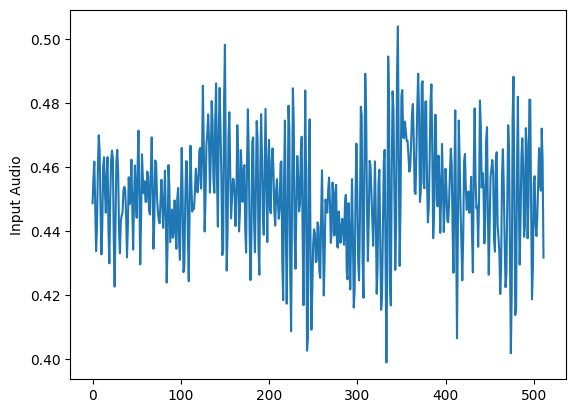

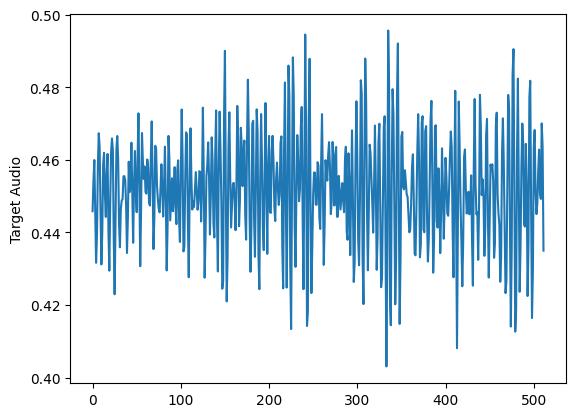

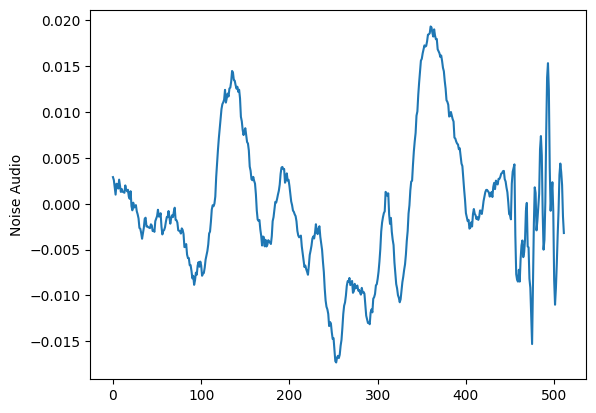

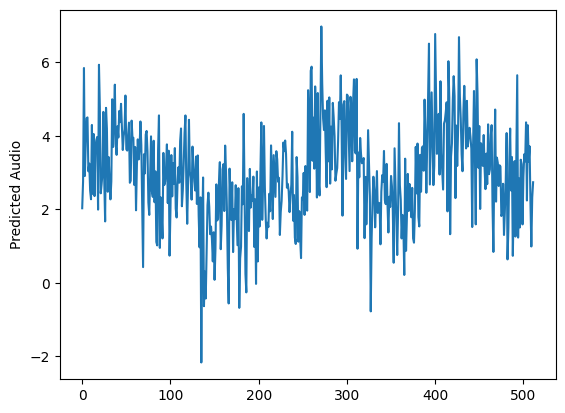

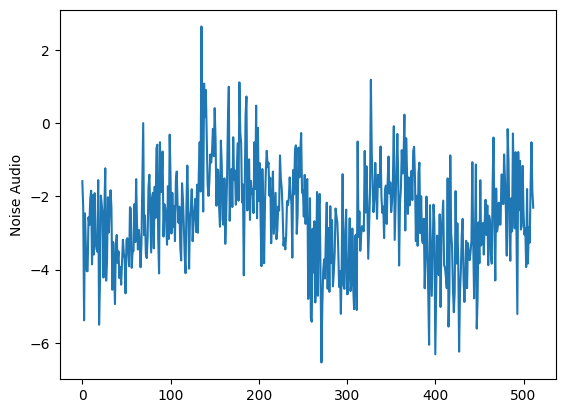

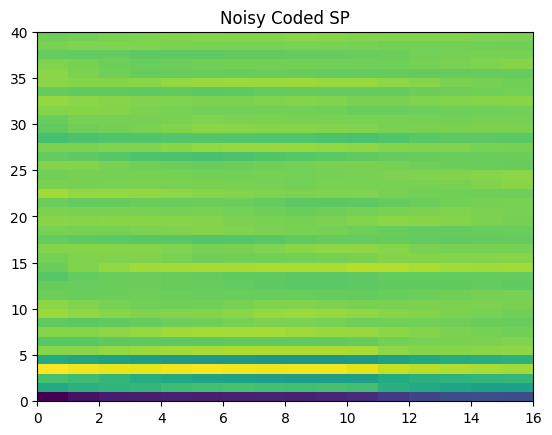

Target  tensor([0.4594, 0.4584])
X_hat  tensor([1.9663, 5.2438])
xau  tensor([0.4428, 0.4416])
torch.Size([1, 1, 512])
torch.Size([512])
tensor(6.3257)
tensor(0.0669)
tensor(0.)


In [5]:
import models.VAEWavenet.WaveVaeDenoiser as WNVAE
import torch
import IPython
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from torch import nn
import torchaudio
import numpy as np
torch.cuda.empty_cache()
import tqdm
from torch.utils.data import DataLoader

mudec = torchaudio.transforms.MuLawDecoding()

newsample = torch.zeros(1, 512)
oldsample = torch.zeros(1, 512)
# datasample = torch.zeros(1, 512)
# spdataset = WNVAE.WaveVaeDataset("./clips", "./traindataset/csp/")
sptest2dataloader = DataLoader(sptestdataset, batch_size=1, shuffle=True, pin_memory = False)
xau, xspec, target, rnnoise = next(iter(sptest2dataloader))

print(xau.size(), xspec.size(), target[:,:,255:257].size())
print(torch.min(xau), torch.max(xau))
print(torch.min(xspec), torch.max(xspec))
print(torch.min(target), torch.max(target))
# print(xau[:, :, :10])




x_hat, mean, var = denoiser(xau.to(device), xspec.to(device), False)

# x_hat = nn.functional.softmax(x_hat, dim=1)

# for i in tqdm.trange(512):
#     probs = xau[:, :, i].data
#     pixel_sample = torch.multinomial(probs, 1).float()
#     pixel_sample = mudec(pixel_sample)
#     oldsample[0, i] = pixel_sample.squeeze()
    

# for i in tqdm.trange(512):
#     probs = x_hat[:, :, i].data
#     pixel_sample = torch.multinomial(probs, 1).float()
#     pixel_sample = mudec(pixel_sample)
#     newsample[0, i] = pixel_sample.squeeze()
    
    
plt.plot(xau.squeeze().detach().cpu().numpy())
plt.ylabel('Input Audio')
plt.show()

plt.plot(target.squeeze().detach().cpu().numpy())
plt.ylabel('Target Audio')
plt.show()

plt.plot(xau.squeeze().detach().cpu().numpy() - target.squeeze().detach().cpu().numpy() )
plt.ylabel('Noise Audio')
plt.show()

plt.plot(x_hat.squeeze().detach().cpu().numpy())
plt.ylabel('Predicted Audio')
plt.show()

plt.plot(xau.squeeze().detach().cpu().numpy() - x_hat.squeeze().detach().cpu().numpy())
plt.ylabel('Noise Audio')
plt.show()


plt.pcolormesh(xspec.squeeze().detach().cpu().numpy())
plt.title("Noisy Coded SP")
plt.show()


# print(newsample.size())
# newsample = newsample.squeeze()
# newsample = newsample.detach().cpu().numpy()
# futuresamplereal = mudec(target).squeeze().squeeze().cpu().numpy()
# xau = xau.squeeze().squeeze()
# xau = xau.detach().cpu().numpy()
# print(np.shape(xau))
# print(np.shape(newsample))
# plt.plot(newsample)
# plt.ylabel('Full Generated')
# plt.show()

# plt.plot(np.append(futuresamplereal, newsample[-1]))
# plt.ylabel('Full Generated')
# plt.show()

# plt.plot(futuresamplereal)
# plt.ylabel('some numbers')
# plt.show()

print('Target ', target.squeeze()[255:257])

print('X_hat ',x_hat.squeeze()[255:257].detach().cpu())
print('xau ',xau.squeeze()[255:257].detach().cpu())
print(x_hat.size())
restimated_noise = xau.detach().cpu().squeeze() - x_hat.detach().cpu().squeeze()
estimated_noise = xau.detach().cpu().squeeze() - xau.detach().cpu().squeeze()
perf_estimated_noise = xau.detach().cpu().squeeze() - target.detach().cpu().squeeze()
print(estimated_noise.squeeze().size())
reproduction_loss = torch.sum(torch.abs(target.squeeze()[255:257].detach().cpu() - x_hat.squeeze()[255:257].detach().cpu()) + torch.abs(rnnoise.squeeze()[255:257].detach().cpu() - estimated_noise[255:257].squeeze().detach().cpu()), dim=0)
worstreproduction_loss = torch.sum(torch.abs(target.squeeze()[255:257].detach().cpu() - xau.squeeze()[255:257].detach().cpu()) + torch.abs(rnnoise.squeeze()[255:257].detach().cpu() - estimated_noise[255:257].squeeze().detach().cpu()), dim=0)
best_reproduction_loss = torch.sum(torch.abs(target.squeeze()[255:257].detach().cpu() - target.squeeze()[255:257].detach().cpu()) + torch.abs(rnnoise.squeeze()[255:257].detach().cpu() - perf_estimated_noise[255:257].squeeze().detach().cpu()), dim=0)
print(reproduction_loss)
print(worstreproduction_loss)
print(best_reproduction_loss)
# print(noisy_audio.size())
# IPython.display.Audio(data = noisy_audio.squeeze().cpu().numpy(), rate = 33000)



In [3]:
from torchaudio.transforms import MuLawEncoding, MFCC, Resample
import librosa

def remove_silent_frames(audio, overlap = 256):
        
    if len(audio.shape) > 1:
        audio = np.ascontiguousarray((audio[:, 0]+audio[:, 1])/2)

    trimmed_audio = []
    indices = librosa.effects.split(audio, hop_length=overlap, top_db=20)

    for index in indices:
        trimmed_audio.extend(audio[index[0]: index[1]])

    return np.array(trimmed_audio)

audiopath = './clips/common_voice_en_33153438.mp3'
audiofile, samplerate = torchaudio.load(audiopath)
zeros = torch.zeros(1, 10000)
audiofile = remove_silent_frames(audiofile.squeeze().numpy())
audiofile = torch.from_numpy(audiofile).unsqueeze(0)
audiofile = torch.cat((zeros, audiofile), 1)
print(audiofile.size())
mfcc_trans = MFCC(samplerate, 64, melkwargs={"hop_length": 33})
mfcc = mfcc_trans(audiofile).squeeze() # Noisy audio spectrum

plt.pcolormesh(mfcc.squeeze().detach().cpu().numpy())
plt.title("Noisy Coded SP")
plt.show()
print(torch.min(mfcc), torch.max(mfcc))

RuntimeError: Failed to open the input "./clips/common_voice_en_33153438.mp3" (No such file or directory).

In [31]:
import models.VAEWavenet.WaveVaeDenoiser as WNVAE
import torch
import IPython
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from torch import nn
import torchaudio
import numpy as np

import tqdm
from torch.utils.data import DataLoader

mudec = torchaudio.transforms.MuLawDecoding()

newsample = torch.zeros(1, 256)
# datasample = torch.zeros(1, 512)
# spdataset = WNVAE.WaveVaeDataset("./clips", "./traindataset/csp/")
sptestdataloader = DataLoader(sptestdataset, batch_size=1, shuffle=True, pin_memory = False)
xau, xspec, target, noisy_audio = next(iter(sptestdataloader))

print(xau.size(), xspec.size(), target.size())

# for i in tqdm.trange(512):
#     probs = target[:, :, i].long().data
#     pixel_sample = torch.multinomial(probs, 1).float()
#     pixel_sample = mudec(pixel_sample)
#     datasample[0, i] = pixel_sample.squeeze()

print(noisy_audio.size())
IPython.display.Audio(data = noisy_audio.squeeze().cpu().numpy(), rate = 33000)


ValueError: not enough values to unpack (expected 4, got 3)

In [14]:
import models.VAEWavenet.WaveVaeDenoiser as WNVAE
import torch
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from torch import nn
import torchaudio
import numpy as np

import tqdm
from torch.utils.data import DataLoader

mudec = torchaudio.transforms.MuLawDecoding()

newsample = torch.zeros(1, 256)
# datasample = torch.zeros(1, 512)
# spdataset = WNVAE.WaveVaeDataset("./clips", "./traindataset/csp/")
sptestdataloader = DataLoader(spdataset, batch_size=1, shuffle=True, pin_memory = False)
xau, xspec, target = next(iter(sptestdataloader))
print(xau.size(), xspec.size(), target.size())
target2 = torch.nn.functional.one_hot(target, num_classes = 256).squeeze().float().permute(1, 0).unsqueeze(0)
print(target2.size())
    
newsample = newsample.unsqueeze(0)
target = target.squeeze().unsqueeze(0)
print(target2[:, :, -1])
print(target[:, -1])
    
print(target2.size(), target.size())
b = target2.size()[0]
# reproduction_loss = torch.nn.functional.cross_entropy(target2, target2, reduce=False).view(b, -1).mean(dim=1)
reproduction_loss = torch.nn.functional.cross_entropy(target.float()[:, -1], target2[:, :, -1], reduction='mean')
print("Reproduction loss:", reproduction_loss.item())

torch.Size([1, 256])
tensor([[185, 183, 182, 183, 184, 184, 182, 180, 180, 183, 185, 185, 183, 182,
         183, 186, 187, 187, 186, 184, 183, 184, 184, 184, 182, 181, 180, 181,
         181, 180, 181, 183, 185, 185, 184, 183, 183, 183, 184, 184, 182, 180,
         179, 180, 183, 183, 181, 178, 180, 184, 186, 186, 184, 182, 181, 182,
         184, 185, 185, 182, 179, 179, 183, 185, 184, 181, 179, 182, 185, 187,
         185, 182, 181, 181, 182, 183, 183, 182, 180, 180, 181, 183, 184, 183,
         183, 183, 184, 185, 185, 184, 182, 181, 181, 182, 183, 182, 180, 178,
         179, 182, 184, 184, 184, 184, 184, 184, 185, 185, 184, 183, 180, 179,
         181, 183, 182, 180, 178, 180, 182, 183, 184, 183, 182, 182, 182, 183,
         184, 183, 183, 182, 182, 182, 181, 181, 180, 181, 182, 183, 183, 183,
         183, 182, 182, 183, 184, 183, 183, 182, 183, 183, 183, 182, 180, 179,
         181, 183, 184, 184, 184, 183, 182, 180, 180, 183, 186, 186, 184, 181,
         181, 182, 184, 185, 18

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

# Training Time

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import models.PixelVAEDenoiser as PAE
import matplotlib.pyplot as plt
import math
from torch import nn
#writer = SummaryWriter()
torch.cuda.empty_cache()
# printGPUInfo()
denoiser.train(True)
actual_kl = 0.5
klmax = 0.5
epochs = 100
valstep = 0


def combined_loss(x, target, mu, log_var, klrate):
    # print("x, target, mu, log_var")
    # print(x.size(), target.size(), mu.size(), log_var.size())
    b = x.size()[0]
    
    # reproduction_loss = loss_fn(x, target).view(b, -1).sum(dim=1)
    # reproduction_loss = torch.nn.functional.cross_entropy(x_hat, target, reduce=False).view(b, -1).mean(dim=1)
    reproduction_loss = torch.nn.functional.cross_entropy(x[:, :, 255:257], target[:, 255:257], reduction='mean')
    reproduction_loss = reproduction_loss * math.log2(math.e)
    # KLD      = 0.5 * torch.sum(log_var.exp() - mu.pow(2) + log_var.exp() - 1, dim=1)
    KLD = torch.mean(-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(),dim=1),dim=0)

    return reproduction_loss + KLD * ((actual_kl % 10) * klmax)

def energy_combined_loss(x, x_hat, target, noise, mu, log_var, klrate):
    b = x.size()[0]

    estimated_noise = x.squeeze() - x_hat.squeeze()
    reproduction_loss = torch.mean(torch.sum(torch.abs(target.squeeze()[:, 255:257] - x_hat.squeeze()[:, 255:257]) + torch.abs(noise.squeeze()[:, 255:257] - estimated_noise[:, 255:257]), dim=1), dim = 0)
    # reproduction_loss = reproduction_loss * math.log2(math.e)
    # KLD      = 0.5 * torch.sum(log_var.exp() - mu.pow(2) + log_var.exp() - 1, dim=1)
    KLD = torch.mean(-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(),dim=1),dim=0)

    return reproduction_loss + KLD * ((actual_kl % 10) * klmax), reproduction_loss




def gen_plot(noisy, denoised, clean):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("Test MSFC result")
        ax1.pcolormesh(noisy)
        ax2.pcolormesh(denoised)
        ax3.pcolormesh(clean)
        return fig

def validate(epoch):
        denoiser.eval()

        total_loss = 0
        total_rec_gen = 0
        total_rec_noise = 0
        step = 0
        with tqdm(enumerate(sptestdataloader),total=len(sptestdataloader),desc=f"Validating.") as t:
            for batch_idx, (x, xspec, target, noise) in t:
                step += 1

                x = x.to(device)
                if x.size()[0] <= 1:
                    step += -1
                    continue
                xspec = xspec.to(device)
                target = target.to(device)
                noise = noise.to(device)

                x_hat, mean, variance = denoiser(x, xspec, False)

                loss, recloss_gen = energy_combined_loss(x, x_hat, target, noise, mean, variance, actual_kl)
                badloss, recloss_noise = energy_combined_loss(x, x, target, noise, mean, variance, actual_kl)
                # loss = combined_loss(x_hat, target.squeeze(), mean, variance, actual_kl)
                total_rec_gen += recloss_gen.item()
                total_rec_noise += recloss_noise.item()

                total_loss += loss.detach().cpu().item()

                t.set_description(f"Validating. Average val loss for step {step}: {total_loss / step}. Recloss: {recloss_gen.item()}")
                
                

                del loss
                del x
                del x_hat
                del mean
                del variance
                del xspec
                del target

        denoiser.train()
        
        
        avg_loss = total_loss/step
        avg_loss_gen = total_rec_gen / step
        avg_loss_noise = total_rec_noise / step
        return avg_loss, avg_loss_gen, avg_loss_noise
    
totalstep = 0
minipoch = 0
for epoch in range(100, 200):
    lossy = 0
    step = 0
    step2 = 0
    

    with tqdm(enumerate(spdataloader),total=len(spdataloader),desc=f"Training. Epoch: {epoch}. Loss for step {step}: {lossy}") as t:
        for batch_idx, (x, xspec, target, noise) in t:
            optimizer.zero_grad(set_to_none=True)
            
            step = batch_idx + 1
            step2 += 1
            # print(batch_idx)
            

            x = x.to(device)
            xspec = xspec.to(device)
            target = target.to(device)
            noise = noise.to(device)

            x_hat, mean, variance = denoiser(x, xspec, True)
            # print(x_hat.size())
            loss, recloss = energy_combined_loss(x, x_hat, target, noise, mean, variance, actual_kl)
            # loss = combined_loss(x_hat, target.squeeze(), mean, variance, actual_kl)
#             ce_loss = torch.nn.functional.cross_entropy(x_hat, target, reduce=False).view(b, -1).sum(dim=1)
#             ce_loss = ce_loss * math.log2(math.e)
            
#             loss = (ce_loss + klloss * 0.01).mean()
            
            # Backwards pass            
            loss.backward()
            optimizer.step()
            curloss = loss.detach().cpu().item() 
            lossy += curloss

            t.set_description(f"Training. Epoch: {round(epoch,2)}. Loss for step {round(step, 2)}: {curloss}, {recloss.item()}. KL Rate = {round((actual_kl % 10) * klmax, 2)}.")
            writer.add_scalar('Train iteration loss', curloss, totalstep)
            totalstep += 1
            
            del loss
            del x
            del x_hat
            del mean
            del variance
            del xspec
            del target
            
            if step % (len(spdataloader) // 40) == 0:
                actual_kl += 0.5
                if ((actual_kl % 10) * klmax) == 0.:
                    klmax += 0.1
                  
                test_loss, gen_test_loss, noise_test_loss = validate(minipoch)
                writer.add_scalar('Train loss', lossy / step2, minipoch)
                lossy = 0
                step2 = 0
                writer.add_scalars('Validation loss', {'Noisy reconstruction':noise_test_loss,
                                    'Denoised reconstruction':gen_test_loss,
                                    'Denoised reconstruction + KL': test_loss}, minipoch)
                # writer.add_scalar(f'check_info/Test noisy loss', noise_test_loss, epoch)
                # writer.add_scalar(f'check_info/Test generated loss', gen_test_loss, epoch)
                # writer.add_scalar(f'check_info/Test generated loss + kl loss', test_loss, epoch)
                torch.save(denoiser.state_dict(), f"./vaemodelsnoisy2/WaveVaeTestModelInbetweenModel{minipoch}")
                minipoch += 1  
                # actual_kl = min(actual_kl, 8.)
            # torch.cuda.empty_cache()
            
    

    
    # adjust_learning_rate(start_epoch, epoch, learning_rate, optimizer)

    
    # writer.add_scalar('Test loss', test_loss, epoch)
    
    

# writer.flush()
torch.save(denoiser.state_dict(), "./vaemodelsnoisy1/WaveVaeTestModel2")

In [6]:
# import torchaudio
# import torch
# audiofile, samplerate = torchaudio.load('./clips/common_voice_en_33153438.mp3' )
# zeros = torch.zeros(1, 20)
# print(torch.min(audiofile), torch.max(audiofile))
# print(audiofile.size())
# print(torch.cat((zeros, audiofile), 1).size())

tensor(-0.3934) tensor(0.4220)
torch.Size([1, 237312])
torch.Size([1, 237332])


In [3]:
torch.save(denoiser.state_dict(), "./vaemodelsaudio/modelnormalised1")

# Test Model

## Load Model

In [1]:
import models.VAEWavenet.WaveVaeDenoiser as WNVAE
import torch
from torch import nn
import numpy as np

# Model hyperparameters
device='cuda:3'

# Model hyperparameters
features = 40
rec_field = 16
upsamples = [2, 2, 2, 2, 2, 2]
latent_space_dim = 64

denoiser = WNVAE.WaveNetVAE(input_size = (features, rec_field), device = device, num_hiddens = 768, dil_rates = upsamples, zsize = latent_space_dim)
denoiser.to(device)

# original saved file with DataParallel
state_dict = torch.load("./vaemodelsnoisy2/WaveVaeTestModelInbetweenModel33")
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
    
denoiser.load_state_dict(new_state_dict)
# denoiser = denoiser.to(device)

[1, 2, 4, 8, 16, 32, 64]
Receptive field =  763.0


<All keys matched successfully>

## Inference TIme

Loading files to dataset. Len clean_files =  0:   0%| | 0/2 [00:00<?, ?it/

.ipynb_checkpoints
common_voice_en_33153439.mp3
../ConvDenoiser_Old/clips/common_voice_en_33153439.mp3 ../ConvDenoiser_Old/urbansound/71177-8-1-4.wav
torch.Size([1, 128000]) torch.Size([1, 128000])


Loading files to dataset. Len clean_files =  63744. :  50%|▌| 1/2 [01:59<0


Samplerate: 32000


Generating!!!: 100%|█████████████████| 1992/1992 [00:07<00:00, 270.01it/s]

~~ Noisy audio ~~ torch.Size([127488])


~~ Target clean audio ~~ torch.Size([127488])


Generating!!!: 100%|██████████████████| 1992/1992 [02:54<00:00, 11.42it/s]


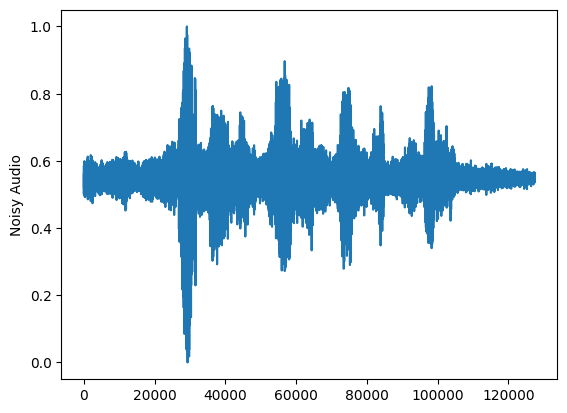

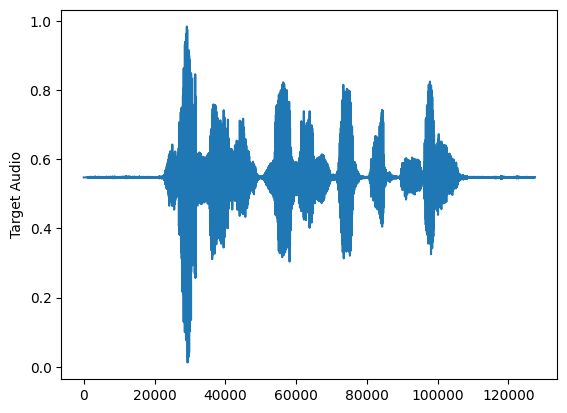

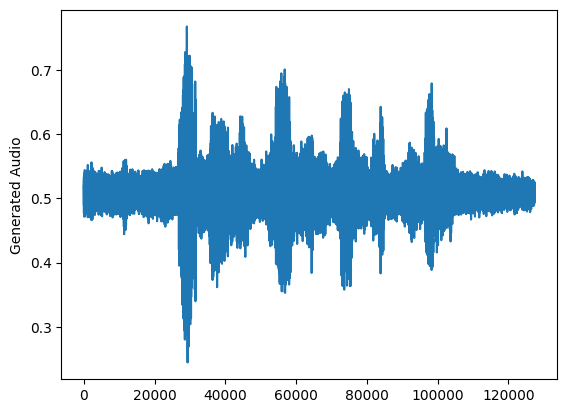

~~ Generated audio ~~


In [5]:
import models.VAEWavenet.WaveVaeDenoiser as WNVAE
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from torch import nn
import torchaudio
import numpy as np
import IPython

import tqdm
from torch.utils.data import DataLoader
denoiser.eval()
mudec = torchaudio.transforms.MuLawDecoding()
batch_size = 32
noisy_audio = torch.zeros(0)
target_audio = torch.zeros(0)
generated_audio = torch.zeros(0)

spdataset = WNVAE.WaveVaeDataset("../ConvDenoiser_Old/clips", "../ConvDenoiser_Old/urbansound", clip_length = 256, clips = 2)
spdataloader = DataLoader(spdataset, batch_size=batch_size, shuffle=False, pin_memory = False)

with tqdm.tqdm(enumerate(spdataloader),total=len(spdataloader),desc=f"Generating!!!") as t:
        for batch_idx, (x, xspec, target, _) in t:
            x = x
            target = target
            for i in range(batch_size):            
                noisy_audio = torch.cat((noisy_audio, x.squeeze().detach().cpu()[i, 255:257].squeeze()), 0)
                target_audio = torch.cat((target_audio, target.squeeze().detach().cpu()[i, 255:257].squeeze()), 0)

print("~~ Noisy audio ~~", noisy_audio.size())
IPython.display.display(IPython.display.Audio(data = noisy_audio.squeeze().cpu().numpy(), rate = 33000))
print("~~ Target clean audio ~~", target_audio.size())
IPython.display.display(IPython.display.Audio(data = target_audio.squeeze().cpu().numpy(), rate = 33000))

with tqdm.tqdm(enumerate(spdataloader),total=len(spdataloader),desc=f"Generating!!!") as t:
        for batch_idx, (x, xspec, target, _) in t:
            x = x.to(device)
            xspec = xspec.to(device)
            target = target.to(device)

            x_hat, mean, variance = denoiser(x, xspec, True)
            
            for i in range(batch_size):            
                # noisy_audio = torch.cat((noisy_audio, x.squeeze().detach().cpu()[i, 255:257].squeeze()), 0)
                generated_audio = torch.cat((generated_audio, x_hat.squeeze().detach().cpu()[i, 255:257].squeeze()), 0)
                # target_audio = torch.cat((target_audio, target.squeeze().detach().cpu()[i, 255:257].squeeze()), 0)
            # print(complete_output.size())
            # print(x_hat.squeeze()[:, -1].unsqueeze(1).size())
            



# print(newsample.size())
# newsample = newsample.squeeze()
# newsample = newsample.detach().cpu().numpy()
# futuresamplereal = mudec(target).squeeze().squeeze().cpu().numpy()
# xau = xau.squeeze().squeeze()
# xau = xau.detach().cpu().numpy()
# print(np.shape(xau))
# print(np.shape(newsample))
# plt.plot(newsample)
# plt.ylabel('Full Generated')
# plt.show()

plt.plot(noisy_audio.detach().cpu().numpy())
plt.ylabel('Noisy Audio')
plt.show()

plt.plot(target_audio.detach().cpu().numpy())
plt.ylabel('Target Audio')
plt.show()

plt.plot(generated_audio.detach().cpu().numpy())
plt.ylabel('Generated Audio')
plt.show()
print("~~ Generated audio ~~")
IPython.display.display(IPython.display.Audio(data = generated_audio.squeeze().cpu().numpy(), rate = 33000))
# print(futuresamplereal[-1])

# print(newsample[-1])

In [6]:
print("~~ Noisy audio ~~", noisy_audio.size())
IPython.display.display(IPython.display.Audio(data = noisy_audio.squeeze().cpu().numpy() - 0.5, rate = 33000))
print("~~ Target clean audio ~~", target_audio.size())
IPython.display.display(IPython.display.Audio(data = target_audio.squeeze().cpu().numpy() - 0.5, rate = 33000))
print("~~ Generated audio ~~")
IPython.display.display(IPython.display.Audio(data = generated_audio.squeeze().cpu().numpy() - 0.5, rate = 33000))




~~ Noisy audio ~~ torch.Size([127488])


~~ Target clean audio ~~ torch.Size([127488])


~~ Generated audio ~~


In [16]:
import models.VAEWavenet.WaveVaeDenoiser as WNVAE
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from torch import nn
import torchaudio
import numpy as np
import IPython

import tqdm

noisy_audio = torch.zeros(0)
target_audio = torch.zeros(0)

# spdataset = WNVAE.WaveVaeDataset("./testdata", "./urbansound", clip_length = 256, clips = 1)
# spdataloader = DataLoader(spdataset, batch_size=1, shuffle=False, pin_memory = False)

with tqdm.tqdm(enumerate(spdataloader),total=len(spdataloader),desc=f"Generating!!!") as t:
        for batch_idx, (x, xspec, target, _) in t:
            x = x
            # xspec = xspec.to(device)
            target = target
            for i in range(batch_size):            
                noisy_audio = torch.cat((noisy_audio, x.squeeze().detach().cpu()[i, 255:257].squeeze()), 0)
                target_audio = torch.cat((target_audio, target.squeeze().detach().cpu()[i, 255:257].squeeze()), 0)
            # print(complete_output.size())
            # print(x_hat.squeeze()[:, -1].unsqueeze(1).size())
            
print(noisy_audio.size())
IPython.display.Audio(data = noisy_audio.squeeze().detach().cpu().numpy(), rate = 33000)

Generating!!!: 100%|████████████████████████████████████████████████████████████| 14112/14112 [00:06<00:00, 2059.87it/s]

torch.Size([112896])


In [5]:
backupsample = complete_output

In [9]:
complete_output = backupsample
print(complete_output[:, 1].size())
newsample = torch.zeros(1)
for i in tqdm.trange(complete_output.size()[1] - 1):
    try:
        probs = complete_output[:, i + 1].unsqueeze(dim = 1).data
        
        pixel_sample = torch.multinomial(probs, 1).float()
        pixel_sample = mudec(pixel_sample)
        newsample = torch.cat((newsample, pixel_sample.squeeze()), 1)
    except:
        print(probs.size())
        continue

torch.Size([256])


  0%|                                                                               | 12/83199 [00:00<12:00, 115.48it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|                                                                               | 25/83199 [00:00<11:35, 119.62it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|                                                                               | 39/83199 [00:00<10:53, 127.34it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|                                                                               | 53/83199 [00:00<10:30, 131.89it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|                                                                               | 68/83199 [00:00<10:16, 134.95it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|                                                                               | 82/83199 [00:00<10:09, 136.36it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|                                                                               | 96/83199 [00:00<10:04, 137.50it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|                                                                              | 110/83199 [00:00<10:06, 137.03it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|                                                                              | 124/83199 [00:00<10:05, 137.09it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▏                                                                             | 138/83199 [00:01<10:05, 137.11it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▏                                                                             | 152/83199 [00:01<10:03, 137.64it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▏                                                                             | 166/83199 [00:01<10:00, 138.30it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▏                                                                             | 181/83199 [00:01<09:57, 138.93it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▏                                                                             | 195/83199 [00:01<09:59, 138.37it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▏                                                                             | 209/83199 [00:01<09:58, 138.65it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▏                                                                             | 223/83199 [00:01<10:23, 133.12it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▏                                                                             | 238/83199 [00:01<10:04, 137.16it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▏                                                                             | 253/83199 [00:01<09:53, 139.87it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▎                                                                             | 268/83199 [00:01<09:46, 141.51it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▎                                                                             | 283/83199 [00:02<09:38, 143.28it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▎                                                                             | 298/83199 [00:02<09:32, 144.73it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▎                                                                             | 313/83199 [00:02<09:28, 145.68it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▎                                                                             | 328/83199 [00:02<09:27, 146.15it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▎                                                                             | 343/83199 [00:02<09:28, 145.87it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▎                                                                             | 358/83199 [00:02<09:28, 145.65it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▎                                                                             | 373/83199 [00:02<09:26, 146.25it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▎                                                                             | 388/83199 [00:02<09:25, 146.48it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  0%|▍                                                                             | 403/83199 [00:02<09:27, 145.80it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▍                                                                             | 418/83199 [00:02<09:29, 145.25it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▍                                                                             | 433/83199 [00:03<09:28, 145.70it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▍                                                                             | 448/83199 [00:03<09:25, 146.23it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▍                                                                             | 463/83199 [00:03<09:25, 146.18it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▍                                                                             | 478/83199 [00:03<09:23, 146.75it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▍                                                                             | 493/83199 [00:03<09:22, 146.95it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▍                                                                             | 508/83199 [00:03<09:21, 147.34it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▍                                                                             | 523/83199 [00:03<09:21, 147.25it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▌                                                                             | 538/83199 [00:03<09:24, 146.49it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▌                                                                             | 553/83199 [00:03<09:23, 146.77it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▌                                                                             | 568/83199 [00:04<09:24, 146.45it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▌                                                                             | 583/83199 [00:04<09:22, 147.00it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▌                                                                             | 598/83199 [00:04<09:23, 146.59it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▌                                                                             | 613/83199 [00:04<09:22, 146.90it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▌                                                                             | 628/83199 [00:04<09:21, 146.95it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▌                                                                             | 643/83199 [00:04<09:20, 147.24it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▌                                                                             | 658/83199 [00:04<09:20, 147.39it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▋                                                                             | 673/83199 [00:04<09:22, 146.84it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▋                                                                             | 688/83199 [00:04<09:24, 146.26it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▋                                                                             | 703/83199 [00:04<09:22, 146.75it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▋                                                                             | 718/83199 [00:05<09:20, 147.05it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▋                                                                             | 733/83199 [00:05<09:22, 146.66it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▋                                                                             | 748/83199 [00:05<09:20, 147.08it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▋                                                                             | 763/83199 [00:05<09:20, 147.01it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▋                                                                             | 778/83199 [00:05<09:22, 146.65it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▋                                                                             | 793/83199 [00:05<09:21, 146.87it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▊                                                                             | 808/83199 [00:05<09:20, 146.93it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▊                                                                             | 823/83199 [00:05<09:19, 147.21it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▊                                                                             | 838/83199 [00:05<09:19, 147.33it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▊                                                                             | 853/83199 [00:05<09:18, 147.52it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▊                                                                             | 868/83199 [00:06<09:17, 147.62it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▊                                                                             | 883/83199 [00:06<09:17, 147.57it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▊                                                                             | 898/83199 [00:06<09:17, 147.73it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▊                                                                             | 913/83199 [00:06<09:16, 147.86it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▊                                                                             | 928/83199 [00:06<09:15, 147.97it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▉                                                                             | 943/83199 [00:06<09:18, 147.25it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▉                                                                             | 958/83199 [00:06<09:18, 147.19it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▉                                                                             | 973/83199 [00:06<09:18, 147.33it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▉                                                                             | 988/83199 [00:06<09:16, 147.65it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▉                                                                            | 1003/83199 [00:06<09:16, 147.65it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▉                                                                            | 1018/83199 [00:07<09:17, 147.44it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▉                                                                            | 1033/83199 [00:07<09:17, 147.47it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▉                                                                            | 1048/83199 [00:07<09:16, 147.59it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▉                                                                            | 1063/83199 [00:07<09:16, 147.70it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|▉                                                                            | 1078/83199 [00:07<09:16, 147.52it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|█                                                                            | 1093/83199 [00:07<09:15, 147.84it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|█                                                                            | 1108/83199 [00:07<09:15, 147.72it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|█                                                                            | 1123/83199 [00:07<09:15, 147.69it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|█                                                                            | 1138/83199 [00:07<09:17, 147.09it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


  1%|█                                                                            | 1152/83199 [00:07<09:28, 144.39it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


KeyboardInterrupt: 

In [7]:
print(newsample.size())
# print(newsample)

torch.Size([21297409])


tensor([ 0., -1., -1.,  ..., -1., -1., -1.])


KeyboardInterrupt: 

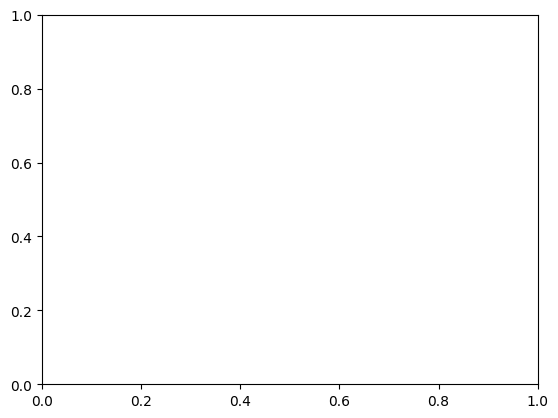

In [8]:
print(newsample)
# newsample = newsample.squeeze()
# newsample = newsample.detach().cpu().numpy()
# futuresamplereal = mudec(target).squeeze().squeeze().cpu().numpy()
# xau = xau.squeeze().squeeze()
# xau = xau.detach().cpu().numpy()
# print(np.shape(xau))
# print(np.shape(newsample))
plt.plot(newsample)
plt.ylabel('Full Generated')
plt.show()

# plt.plot(np.append(xau[-511:] * 2 - 1, newsample[-1]))
# plt.ylabel('Full Generated')
# plt.show()

# plt.plot(futuresamplereal)
# plt.ylabel('some numbers')
# plt.show()

# print(futuresamplereal[-1])

# print(newsample)